<a href="https://colab.research.google.com/github/nkolln/DataChallenge1/blob/master/CyberTruck_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps

  Cloning git://github.com/fchollet/keras.git to /tmp/pip-req-build-cn26bbvp
  Running command git clone -q git://github.com/fchollet/keras.git /tmp/pip-req-build-cn26bbvp
  Created wheel for Keras: filename=Keras-2.3.1-cp36-none-any.whl size=365121 sha256=d65dc79a6b218d893f4113b5270837be17746c8eb11278675766766f21074e28
  Stored in directory: /tmp/pip-ephem-wheel-cache-xmrns6mh/wheels/dc/a7/a2/8b2d0fd23dee9c609b4c95f2b5ed27997ed17ccbeabbebfc64
Successfully built Keras
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Importing all necessary libraries.

In [2]:
%tensorflow_version 1.x
import itertools
import multiprocessing.pool
import threading
from functools import partial
from keras.models import load_model
from keras.models import Model
import keras
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.backend import relu, sigmoid
import numpy as np
import time
import argparse
import glob
import json
import os
import numpy as np
from tensorflow.python.lib.io import file_io
from skimage import exposure, color
import tensorflow as tf
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.contrib.session_bundle import exporter
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from matplotlib import pyplot as plt
from numpy import loadtxt

Using TensorFlow backend.


#Setting up the model

Creating a Sequential Model with Keras which has 3 convolutional layers, 2 max pooling layers in order to down sample input representations. Furthermore, relu activations is used to increase non-linearity in one of the dense layers. In the other dense layer, softmax is used as activation.

Also, Adam learning rate optimizer is used with a small starting value of 0.01. 

As a loss-function categorical crossentropy is being used.


In [0]:
def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""

    model = models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(128, 128, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(labels_dim, activation='softmax', kernel_initializer='glorot_uniform'))

    compile_model(model)
    return model

def compile_model(model):
    opt =keras.optimizers.SGD(lr=0.01, momentum=0.99, decay = 0.01)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def read_train_data():
    start_time = time.time()
    print("Start Read Train Data")
    data = np.load("trainDataSmall.npz")
    #data = np.load("/content/drive/My Drive/Colab Notebooks/trainDataSmall.npz")
    print("Train data read --- %s seconds ---" % (time.time() - start_time))
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    print("Training - Total examples per class", np.sum(Y_train, axis=0))
    return [X_train, Y_train]

def read_test_data():
    start_time = time.time()
    print("Start Read Test Data")
    data = np.load("testDataSmall.npz")
    print("Test data read --- %s seconds ---" % (time.time() - start_time))
    X_test = data["X_test"]
    Y_test = data["Y_test"]
    print("Testing - Total examples per class", np.sum(Y_test, axis=0))
    return [X_test, Y_test]

Downloading the training and test data from the TU/e server.

In [0]:
![ -f testDataSmall.npz ] || wget -O testDataSmall.npz "https://www.win.tue.nl/~cdecampos/testDataSmall.npz"
![ -f trainDataSmall.npz ] || wget -O trainDataSmall.npz "https://www.win.tue.nl/~cdecampos/trainDataSmall.npz"

Implementing adaptive histogram equalization as a preprocessing tool in the continous evaluation class.

In [5]:
def AHE(image):
    image = exposure.equalize_adapthist(image, clip_limit=0.01)
    
                    
datagen1 = ImageDataGenerator(
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        preprocessing_function=AHE
        )

class ContinuousEval(keras.callbacks.Callback):
    """Continuous eval callback to evaluate the checkpoint once
       every so many epochs.
    """

    def __init__(self,
                 eval_frequency,
                 job_dir):
        self.eval_frequency = eval_frequency
        self.job_dir = job_dir
        [self.X_test, self.Y_test] = read_test_data()
        datagen1.fit(self.X_test)

    def on_epoch_begin(self, epoch, logs={}):
        if epoch > 0 and epoch % self.eval_frequency == 0:
            # Unhappy hack to work around h5py not being able to write to GCS.
            # Force snapshots and saves to local filesystem, then copy them over to GCS.
            model_path_glob = 'checkpoint.*'
            model_path_glob = os.path.join(self.job_dir, model_path_glob)
            checkpoints = glob.glob(model_path_glob)
            if len(checkpoints) > 0:
                checkpoints.sort()
                retinopathy_model = load_model(checkpoints[-1])
                retinopathy_model = compile_model(retinopathy_model)
                loss, acc = retinopathy_model.evaluate(
                    self.X_test, self.Y_test)
                print('\nEvaluation epoch[{}] metrics[{:.2f}, {:.2f}] {}'.format(
                    epoch, loss, acc, retinopathy_model.metrics_names))
            else:
                print('\nEvaluation epoch[{}] (no checkpoints found)'.format(epoch))
                
# Continuous eval callback
evaluation = ContinuousEval(5, 'job_dir')
validation=(evaluation.X_test, evaluation.Y_test)

Start Read Test Data
Test data read --- 0.002942323684692383 seconds ---
Testing - Total examples per class [500. 500. 500. 500. 500.]


# Training the model
The model used # epochs and # batch size. Furthermore, some image augmentation techniques are implemented in the image-generator function. In the end, two plots are produced which show the accuracy and loss per epoch for the test and train data.

In [0]:
"""This code implements a Feed forward neural network using Keras API."""

CLASS_SIZE = 5
FILE_PATH = 'checkpoint.{epoch:02d}.hdf5'
RETINOPATHY_MODEL = 'retinopathy.hdf5'

def run():
    tf.keras.backend.clear_session()
    #local dir to write checkpoints and export model
    job_dir = 'jobdir'
    #Batch size for training steps
    train_batch_size = 150
    #Maximum number of epochs on which to train
    num_epochs = 50
    #Checkpoint per n training epochs
    checkpoint_epochs = 5
    #Perform one evaluation per n epochs
    eval_frequency = 5

    retinopathy_model = model_fn(CLASS_SIZE)

    try:
        os.makedirs(job_dir)
    except:
        pass

    # Unhappy hack to work around h5py not being able to write to GCS.
    # Force snapshots and saves to local filesystem, then copy them over to GCS.
    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        period=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        write_graph=True,
        embeddings_freq=0)

    callbacks = [checkpoint, evaluation, tblog]

    [X_train, Y_train] = read_train_data()
    datagen1.fit(X_train)
    
    datagen = ImageDataGenerator(
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True)
    
    history = retinopathy_model.fit_generator(
        datagen.flow(X_train, Y_train, batch_size=train_batch_size),
        steps_per_epoch=100,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=2,
        validation_data=validation)

    retinopathy_model.save(os.path.join(job_dir, RETINOPATHY_MODEL))
    retinopathy_model.summary()
    
    # Creating a plot for loss and accuracy for both training and validation set.
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], 'bo')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'test_acc'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], 'bo')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('Training and Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'test_loss'], loc='upper left')
    plt.show()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Start Read Train Data
Train data read --- 0.000518798828125 seconds ---
Training - Total examples per class [1000. 1000. 1000. 1000. 1000.]



Epoch 1/50
 - 13s - loss: 1.6111 - accuracy: 0.2080 - val_loss: 1.6067 - val_accuracy: 0.2140

Epoch 2/50
 - 11s - loss: 1.6069 - accuracy: 0.2148 - val_loss: 1.5996 - val_accuracy: 0.2248
Epoch 3/50
 - 11s - loss: 1.5922 - accuracy: 0.2478 - val_loss: 1.5664 - val_accuracy: 0.2936
Epoch 4/50
 - 11s - loss: 1.5698 - accuracy: 0.2708 - val_loss: 1.5001 - val_accuracy: 0.3376
Epoch 5/50
 - 11s - loss: 1.5275 - accuracy: 0.2932 - val_loss: 1.4453 - val_accuracy: 0.3120

Epoch 00005: saving model to jobdir/checkpoint.05.hdf5
Epoch 6/50

Evaluation epoch[5] (no checkpoints found)
 - 11s - loss: 1.5174 - accuracy: 0.2918 - val_loss: 1.4487 - val_accuracy: 0.3332
Epoch 7/50
 - 11s - loss: 1.5086 - accuracy: 0.2924 - val_loss: 1.4313 - val_accuracy: 0.3404
Epoch 8/50
 - 11

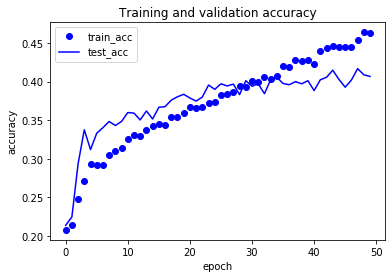

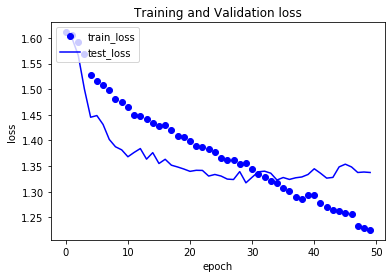

In [7]:
!rm -fr jobdir/
run()

# Additional metrics
In the cells below, some further metrics and diagnostics are implemented. Such are confusion matrix, f-1 statistics and a model prediction tool.

In [0]:
model = load_model('jobdir/retinopathy.hdf5')

data = np.load("testDataSmall.npz")
X_test = data["X_test"]
Y_test = data["Y_test"]

yProbTest = model.predict_proba(X_test)
yClassTest = model.predict_classes(X_test)

Enter number of the test case: 5
Predicted Class = 3, Actuall Class = 0


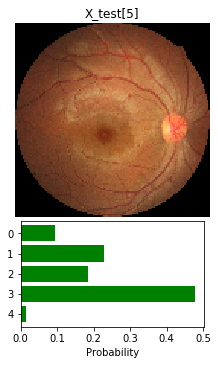

In [9]:
def convert_act(yInput):
  if(yInput == [1, 0, 0, 0, 0]).all():
    return 0
  elif(yInput == [0, 1, 0, 0, 0]).all():
    return 1
  elif(yInput == [0, 0, 1, 0, 0]).all():
    return 2
  elif(yInput == [0, 0, 0, 1, 0]).all():
    return 3
  elif(yInput == [0, 0, 0, 0, 1]).all():
    return 4

val = input("Enter number of the test case: ") 

imgToShow = tf.keras.preprocessing.image.array_to_img(
    X_test[int(val)],
    data_format=None,
    scale=True,
    dtype=None
)

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

ax1.axis('off')
ax1.set_title("X_test[%s]" % (val))
ax1.imshow(imgToShow)
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([0,1,2,3,4])
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, yProbTest[int(val)], xerr=0, align='center', color='green')

print("Predicted Class = %s, Actuall Class = %s" % (yClassTest[int(val)], convert_act(Y_test[int(val)])))
plt.show()

In [0]:
new_Y_test = []

for x in range(len(Y_test)):
  new_Y_test.append(convert_act(Y_test[x]))

In [0]:
cm = confusion_matrix(new_Y_test, yClassTest)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


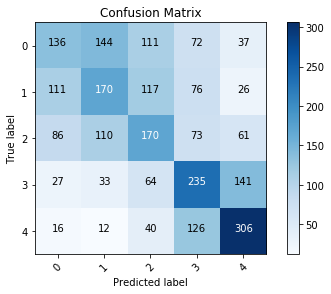

In [13]:
cm_plot_labels = [0, 1, 2, 3, 4]
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [14]:
print(classification_report(new_Y_test, yClassTest))

              precision    recall  f1-score   support

           0       0.36      0.27      0.31       500
           1       0.36      0.34      0.35       500
           2       0.34      0.34      0.34       500
           3       0.40      0.47      0.43       500
           4       0.54      0.61      0.57       500

    accuracy                           0.41      2500
   macro avg       0.40      0.41      0.40      2500
weighted avg       0.40      0.41      0.40      2500

